<h1><center><b>Coastal Altimetry</b></center></h1>
<p><b>Challenges with coastal altimetry</b></p>
<p>1. The various corrections applied to the altimeter measurements that are usually less accurate at the coast. Consequently, most altimeter data near land are flagged as invalid and eliminated from the standard products.</p>
   <p> 2. Radar echoes are severely contaminated by the nearby land surface, leading to complex waveforms significantly departing from that of open ocean.</p>

<b>Coastal Altimetry Products Available</b>
<p> 1. X-TRACK : does not apply waveform retracking; based on improved geophysical corrections near the coast</p>
<p> 2. PISTACH</p>
<p>3. ALES</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.special import erf
import os
from netCDF4 import Dataset

<h1><center><b>Study Area</b></center></h1>
<p>Study area has two passes of <b>Jason-1</b>, pass no. <b>14</b> and <b>231</b>. Retrached waveforms corresponding to pass no. 14 on <b>24-05-2012 16:59:42</b></p>

<h1><center><b>Importing Files and Extracting Variables</b></center></h1>
<p>For each location there are 20, 20hz ku band waveform samples</p>

In [3]:
os.chdir('C:\\Users\\Omen\\OneDrive\\Desktop\\Retracking_Algorithms')
os.getcwd()

'C:\\Users\\Omen\\OneDrive\\Desktop\\Retracking_Algorithms'

In [4]:
nc = Dataset('Jason1_09_11\\pass014\\JA1_GPS_2PcP262_014_20090210_180348_20090210_190000.nc')

In [5]:
nc.variables

{'time': <class 'netCDF4._netCDF4.Variable'>
 float64 time(time)
     long_name: time (sec. since 2000-01-01)
     standard_name: time
     calendar: gregorian
     tai_utc_difference: 34.0
     leap_second: 0000-00-00T00:00:00.000000
     units: seconds since 2000-01-01 00:00:00.0
     comment: [tai_utc_difference] is the difference between TAI and UTC reference time (seconds) for the first measurement of the data set. [leap_second] is the UTC time at which a leap second occurs in the data set, if any. After this UTC time, the tai_utc_difference is increased by 1 second.
 unlimited dimensions: 
 current shape = (2711,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'meas_ind': <class 'netCDF4._netCDF4.Variable'>
 int8 meas_ind(meas_ind)
     long_name: elementary measurement index
     units: count
     comment: Set to be compliant with the CF-1.1 convention
 unlimited dimensions: 
 current shape = (20,)
 filling on, default _FillValue of -127 ignored,
 'wvf_ind': <cl

In [6]:
waveforms = nc.variables['waveforms_20hz_ku'][:]
thermal_noise = nc.variables['thermal_noise_20hz_ku'][:]
amplitude = nc.variables['amplitude_20hz_ku'][:]
width_lead_edge = nc.variables['width_leading_edge_20hz_ku'][:]
epoch = nc.variables['epoch_20hz_ku'][:]
peakiness = nc.variables['peakiness_20hz_ku'][:]
mqe = nc.variables['mqe_20hz_ku'][:]
off_nadir_angle_sq = nc.variables['off_nadir_angle_wf_ku'][:] 
swh = nc.variables['swh_20hz_ku'][:]
lon = nc.variables['lon'][:]
lat = nc.variables['lat'][:]
ice_range = nc.variables['ice_range_20hz_ku'][:]
cog_corr = nc.variables['cog_corr'][:]
uso_corr = nc.variables['uso_corr'][:]
internal_path_delay = nc.variables['internal_path_delay_corr_ku'][:]
doppler_corr = nc.variables['doppler_corr_ku'][:]
#modeled_instr_corr = nc.variables['modeled_instr_corr_ku'][:]
net_instr_corr = nc.variables['net_instr_corr_range_ku'][:]
#iono_corr = nc.variables['iono_cor_alt_ku'][:]
model_dry_tropo = nc.variables['model_dry_tropo_corr'][:]
rad_wet_tropo = nc.variables['rad_wet_tropo_corr'][:]
sea_state_bias = nc.variables['sea_state_bias_ku'][:]
solid_earth_tide = nc.variables['solid_earth_tide'][:]
ocean_tide = nc.variables['ocean_tide_sol1'][:]
pole_tide = nc.variables['pole_tide'][:]
bar_corr = nc.variables['inv_bar_corr'][:]
hf = nc.variables['hf_fluctuations_corr'][:]
geoid = nc.variables['geoid'][:]

In [7]:
waveforms.shape

(2711, 20, 104)

In [8]:
cog_corr.shape

(2711,)

In [9]:
uso_corr.shape

(2711,)

In [10]:
internal_path_delay.shape

(2711,)

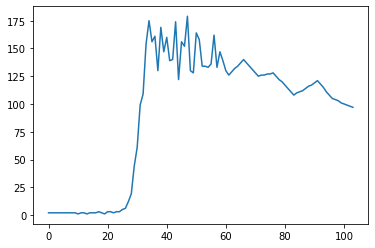

In [11]:
plt.plot(waveforms[0,19])

<h1><center><b>OCOG Algorithm</b></center></h1>
<p>OCOG is a robust re-tracking method based on finding the <b>centre of gravity</b> of waveforms. It is a <b>purely statistical</b> approach and does not involve function fitting. One of the major advantages of this algorithm is that <b>it can be applied for all cases</b>, and there is no chance of failure.</p>
<p>Based on the effective centre of gravity rectangle, the amplitude <b>(A)</b>, width of rectangle <b>(W)</b>, the centre of gravity <b>(COG)</b> and Leading edge Position <b>(LEP)</b> can be estimated as follows:</p>

<p> It is also the algorithm behind <b>Ice-1 retracker</b> being used in Jason-1 retracking.

In [12]:
def OCOG(w, n1=0, n2=0):
    import numpy as np
    w = w[n1:len(w)-n2]
    mini = np.min(w)
    maxi = np.max(w)
    w = (w - mini)/(maxi-mini)
    P_4 = np.sum(w**4)
    P_2 = np.sum(w**2)
    A = np.sqrt(P_4/P_2)
    W = (P_2**2)/P_4
    COG = np.dot(np.arange(n1,len(w) - n2, 1),w**2)/P_2
    LEP = COG - (W/2)
    return A*(maxi-mini)+mini, W, COG, LEP

In [13]:
OCOG(waveforms[0,0])

(144.7168133537558, 65.82214640462308, 61.39542340155569, 28.484350199244147)

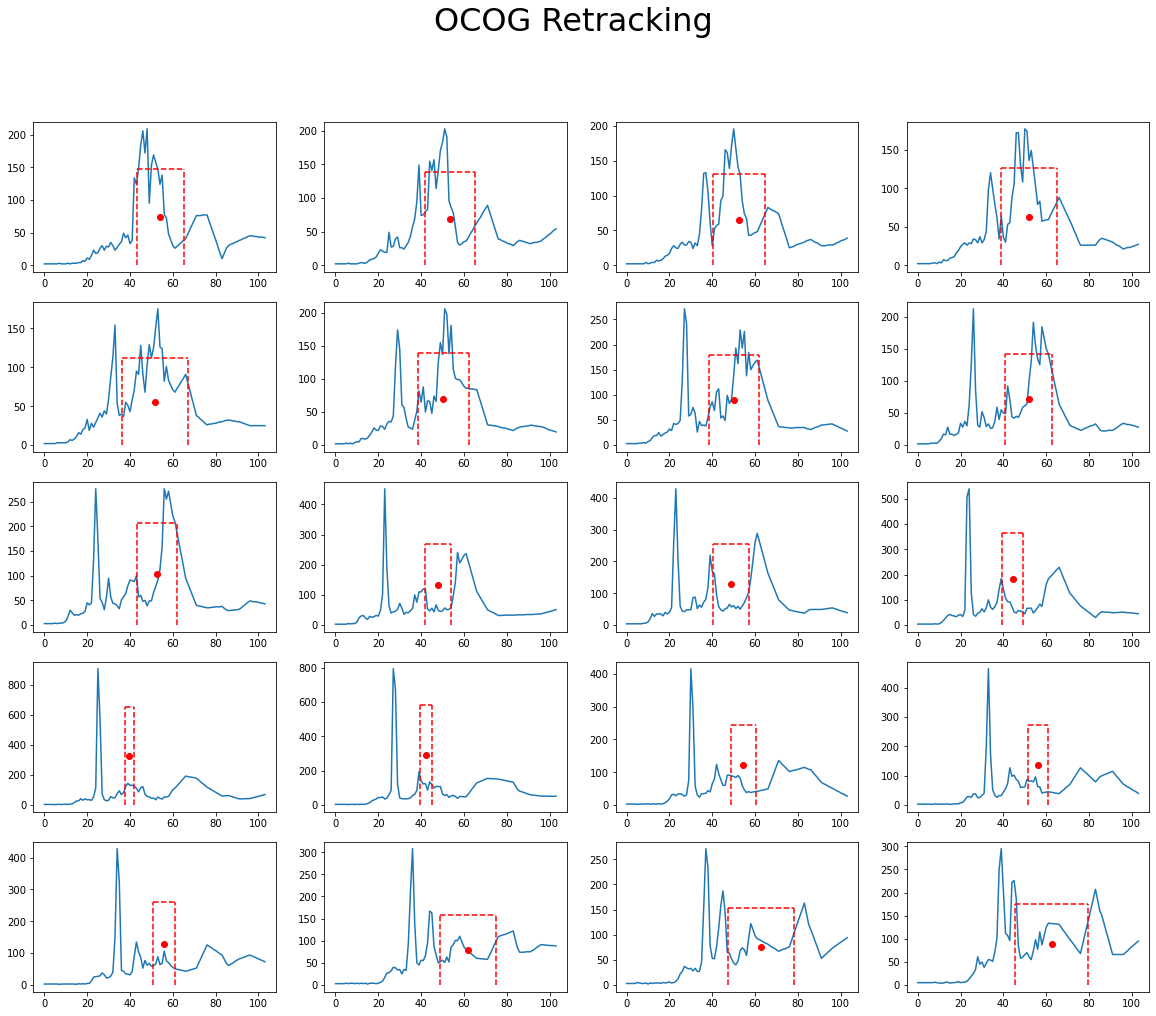

In [14]:
plt.figure(figsize = (20,16))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.plot(waveforms[300,i])
    A,W,COG,LEP = OCOG(waveforms[300,i])
    plt.plot([LEP, LEP+W],[A,A],color = 'red', linestyle = 'dashed' )
    plt.plot([LEP,LEP],[0,A],color = 'red', linestyle = 'dashed' )
    plt.plot([LEP + W,LEP + W],[0,A],color = 'red', linestyle = 'dashed' )
    plt.plot(COG,A/2,color = 'red', marker = 'o')
#plt.supxlabel('Bins')
#plt.supylabel('Return Power')
plt.suptitle('OCOG Retracking', fontsize=32)
plt.show()

<h3>Storing Re-tracked data for comparison</h3>

In [15]:
OCOG_data = np.zeros((2697,20,4))
for i in range(2697):
    for j in range(20):
        OCOG_data[i,j,0], OCOG_data[i,j,1], OCOG_data[i,j,2], OCOG_data[i,j,3] = OCOG(waveforms[i,j])

<ipython-input-12-607ca2a62a25>:11: RuntimeWarning: divide by zero encountered in true_divide
  COG = np.dot(np.arange(n1,len(w) - n2, 1),w**2)/P_2
<ipython-input-15-c756a74e4276>:4: UserWarning: Warning: converting a masked element to nan.
  OCOG_data[i,j,0], OCOG_data[i,j,1], OCOG_data[i,j,2], OCOG_data[i,j,3] = OCOG(waveforms[i,j])
<ipython-input-12-607ca2a62a25>:11: RuntimeWarning: invalid value encountered in true_divide
  COG = np.dot(np.arange(n1,len(w) - n2, 1),w**2)/P_2


<h3>Writing OCOG Function to file</h3>

In [16]:
import inspect
import os

def write_agent_to_file(function, file):
    with open(file, "w") as f:
        f.write(inspect.getsource(function))
        print(function, "written to", file)

write_agent_to_file(OCOG, "OCOG.py")

<function OCOG at 0x000001D4128D8280> written to OCOG.py


<h1><center><b>ALES Retracking</b></center></h1>


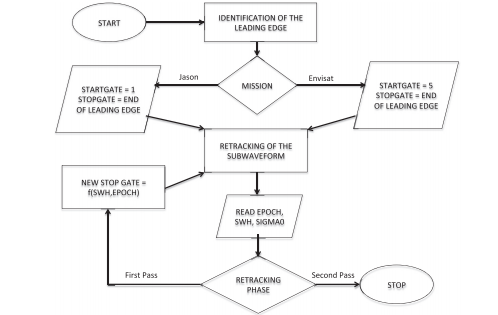

In [17]:
display.Image("1-s2.0-S0034425714000534-main.pdf and 4 more pages - Profile 1 - Microsoft​ Edge 21-07-2021 11_49_48.png")

In [18]:
def ALES(waveform, epi, SWHi=0.5, Pi=1, taui=0.005*3.125e-9):
    import numpy as np
    from scipy.special import erf
    from scipy.optimize import minimize
    
    def normalize(waveform):
        avg_8 = np.zeros(len(waveform)-7)
        for i in range(0,len(waveform)-7):
            avg_8[i] = np.sum(waveform[i:i+8])/8
        waveform = waveform/max(avg_8)
        return waveform
    
    def Brown_Hayne(SWH,tau,P_n,t,ep):
        gamma = np.sin(1.29*np.pi/180)*np.sin(1.29*np.pi/180)*0.721
#       print(gamma)
        a_e = np.exp(-4*np.sin(ep*np.pi/180)*np.sin(ep*np.pi/180)/gamma)
#       print(a_e)
        sigma_s = SWH/(2*2.99792e8)
#       print(sigma_s)
        sigma_c = np.sqrt((1.65e-9*1.65e-9 + sigma_s*sigma_s))
#       print(sigma_c)
        b_e = np.cos(2*ep*np.pi/180)- (np.sin(2*ep*np.pi/180)*np.sin(2*ep*np.pi/180)/gamma)
#       print(b_e)
        a = 4*2.99792e8/(gamma*1336000*(1 + 1336000/6371000))
#       print(a)
        c_e = b_e * a
#       print(c_e)
        u = (t - tau- sigma_c*sigma_c*c_e)/(1.414*sigma_c)
#       print(u)
        v = c_e*(t - tau - (c_e*sigma_c*sigma_c/2))
#       print(v)
        V_m = a_e*P_n*((1+erf(u))/2)*np.exp(-v)
        return V_m
    
    w = normalize(waveform)
    T_n = np.sum(w[0:6])/6
    w = w - T_n
    
    
    def lead_edge_detection(w):
        Dwf = np.zeros(len(w)-1)
        for i in range(1,len(w)):
            Dwf[i-1] = w[i] - w[i-1]
            
        def edge_top_detection(edge_foot):
            for i in range(edge_foot,len(Dwf)):
                if Dwf[i] < 0:
                    edge_top = i
                    break    
            return edge_top
        
        def check(edge_top):
            for i in range(edge_top,edge_top+4):
                if w[i] < 0.10:
                    return 1
        
        for i in range(len(Dwf)):
            if Dwf[i] > 0.01:
                edge_foot = i
                break

        edge_top = edge_top_detection(edge_foot)
                
        flag = check(edge_top)       
    
        while flag:
            edge_foot = edge_top + 1
            edge_top = edge_top_detection(edge_foot)
            flag = check(edge_foot)
            
        return edge_top
    
    
    stop_gate = lead_edge_detection(w) + 1
    subwaveform = w[0:stop_gate]
    tol = 1e-10
    Nmax = 600
    
    def residual(b,P,t,ep):
        return np.dot((P-Brown_Hayne(b[0],b[1],b[2],t,ep)),(P-Brown_Hayne(b[0],b[1],b[2],t,ep))) 
    
    
    t = np.arange(0,stop_gate*3.125e-9,3.125e-9)
    if len(t) != len(subwaveform):
            t = t[0:len(subwaveform)]
    if stop_gate >= 104:
        print('failure')
        return [0.5,0,0.1], 33, -0.5
    res = minimize(residual,[SWHi,taui,Pi],args=(subwaveform,t,0),method='Nelder-Mead',tol = tol, options={'maxiter':Nmax})
    flag1 = True 
    if res.success:
        flag1 = False
        
    while flag1:
        stop_gate = stop_gate + 1
        if stop_gate >= 104:
            print('failure')
            return [0.5,0,0.1],33, -0.5
        subwaveform = w[0:stop_gate]
        t = np.arange(0,stop_gate*3.125e-9,3.125e-9)
        if len(t) != len(subwaveform):
            t = t[0:len(subwaveform)]
        res = minimize(residual,[SWHi,taui,Pi],args=(subwaveform,t,0),method='Nelder-Mead',tol = tol, options={'maxiter':Nmax})
        flag1 = res.success
        
    SWHi = res.x[0]
    taui = res.x[1]
    Pi = res.x[2]
    max_gate = np.ceil(res.x[1]+33 + 1.3737 + 4.5098*res.x[0])
    if max_gate < 0:
        print('failure')
        return [0.5,0,0.1],33,-0.5
    subwaveform = w[0:int(max_gate)]
    if max_gate >= 104:
        print('failure')
        return [0.5,0,0.1],33, -0.5
    t = np.arange(0,max_gate*3.125e-9,3.125e-9)
    if len(t) != len(subwaveform):
        t = t[0:len(subwaveform)]
    res = minimize(residual,[SWHi,taui,Pi],args=(subwaveform,t,0),method='Nelder-Mead',tol = tol, options={'maxiter':Nmax})
    
    flag2 = True
    if res.success:
        flag2 = False
        
    while flag2:
        max_gate = max_gate + 1
        subwaveform = w[0:int(max_gate)]
        if max_gate >= 104:
            print('failure')
            return [0.5,0,0.1],33, -0.5
        t = np.arange(0,max_gate*3.125e-9,3.125e-9)
        if len(t) != len(subwaveform):
            t = t[0:len(t)-1]
        res = minimize(residual,[0.5,0.005*3.125e-9,Pi],args=(subwaveform,t,0),method='Nelder-Mead',tol = tol, options={'maxiter':Nmax})
        flag2 = res.success
        
    return res.x,max_gate,T_n
    

In [19]:
def normalize(waveform):
        avg_8 = np.zeros(len(waveform)-7)
        for i in range(0,len(waveform)-7):
            avg_8[i] = np.sum(waveform[i:i+8])/8
        waveform = waveform/max(avg_8)
        return waveform
    
def Brown_Hayne(SWH,tau,P_n,t,ep):
        gamma = np.sin(1.29*np.pi/180)*np.sin(1.29*np.pi/180)*0.721
#       print(gamma)
        a_e = np.exp(-4*np.sin(ep*np.pi/180)*np.sin(ep*np.pi/180)/gamma)
#       print(a_e)
        sigma_s = SWH/(2*2.99792e8)
#       print(sigma_s)
        sigma_c = np.sqrt((1.65e-9*1.65e-9 + sigma_s*sigma_s))
#       print(sigma_c)
        b_e = np.cos(2*ep*np.pi/180)- (np.sin(2*ep*np.pi/180)*np.sin(2*ep*np.pi/180)/gamma)
#       print(b_e)
        a = 4*2.99792e8/(gamma*1336000*(1 + 1336000/6371000))
#       print(a)
        c_e = b_e * a
#       print(c_e)
        u = (t - tau- sigma_c*sigma_c*c_e)/(1.414*sigma_c)
#       print(u)
        v = c_e*(t - tau - (c_e*sigma_c*sigma_c/2))
#       print(v)
        V_m = a_e*P_n*((1+erf(u))/2)*np.exp(-v)
        return V_m
    

failure
failure
failure
failure


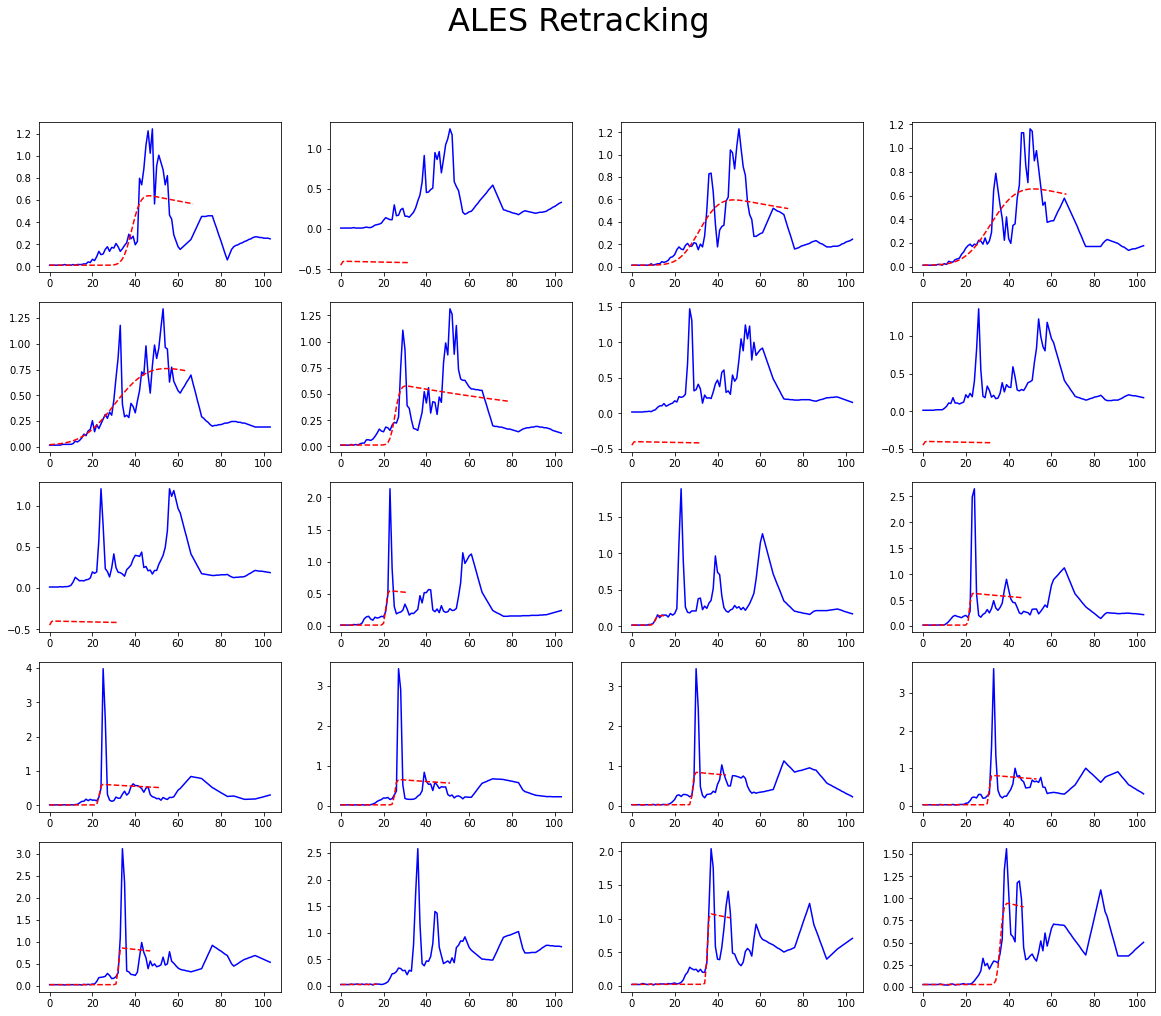

In [20]:
plt.figure(figsize = (20,16))
for i in range(20):
    plt.subplot(5,4,i+1)
    ales,max_gate,T_n = ALES(waveforms[300,i],0)
    plt.plot(normalize(waveforms[300,i]),color='blue')
    plt.plot(Brown_Hayne(ales[0], ales[1], ales[2],np.arange(0,max_gate*3.125e-9,3.125e-9),0)+T_n,color='red',linestyle='--')
  #  plt.plot([LEP + W,LEP + W],[0,A],color = 'red', linestyle = 'dashed' )
  #  plt.plot(COG,A/2,color = 'red', marker = 'o')
#plt.supxlabel('Bins')
#plt.supylabel('Return Power')
plt.suptitle('ALES Retracking', fontsize=32)
plt.show()

<h3>Writing ALES to file</h3>

In [21]:
write_agent_to_file(ALES, "ALES.py")

<function ALES at 0x000001D415403EE0> written to ALES.py


In [22]:
from scipy.signal import savgol_filter

In [23]:
w = waveforms[300, :]
w.shape

(20, 104)

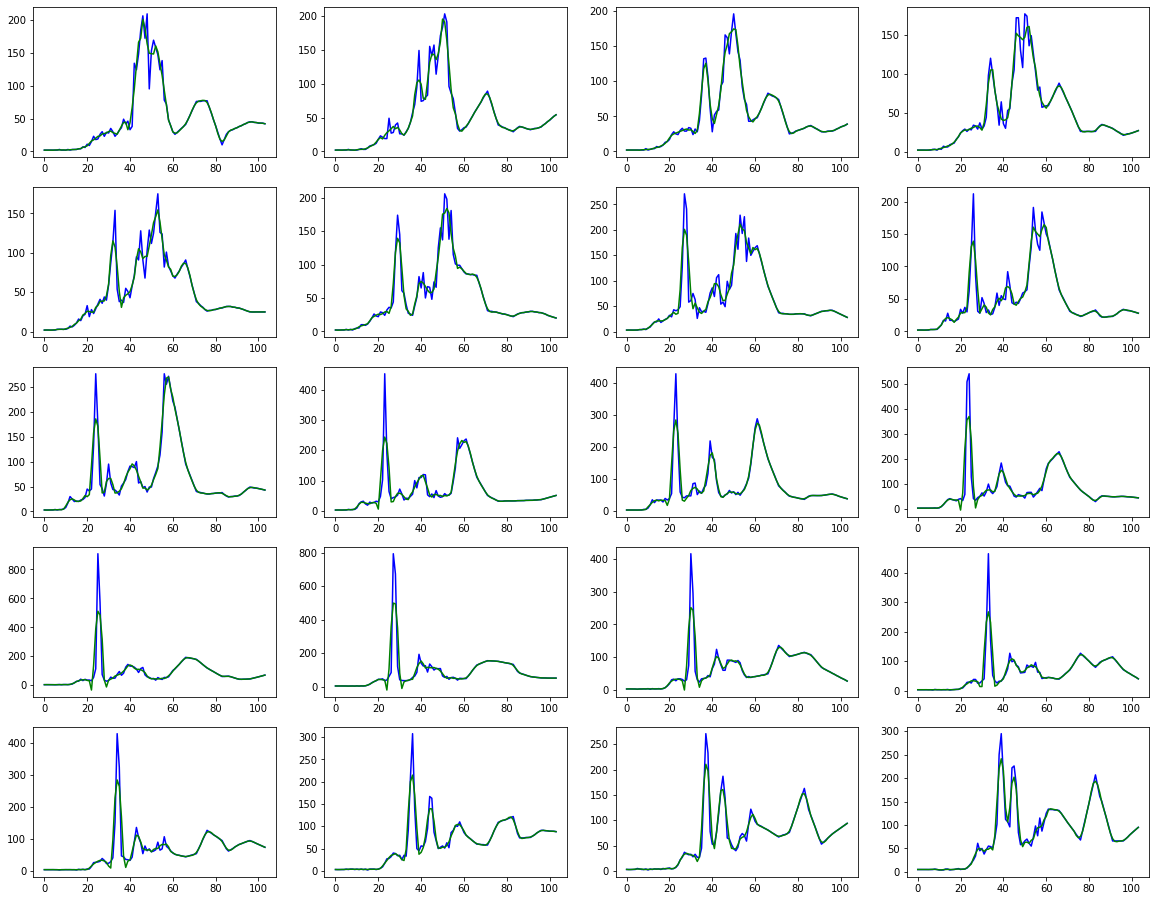

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,16))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.plot(w[i],color='blue')
    plt.plot(savgol_filter(w[i],7,3),color='green')
    w[i] = savgol_filter(w[i],7,3)

failure
failure


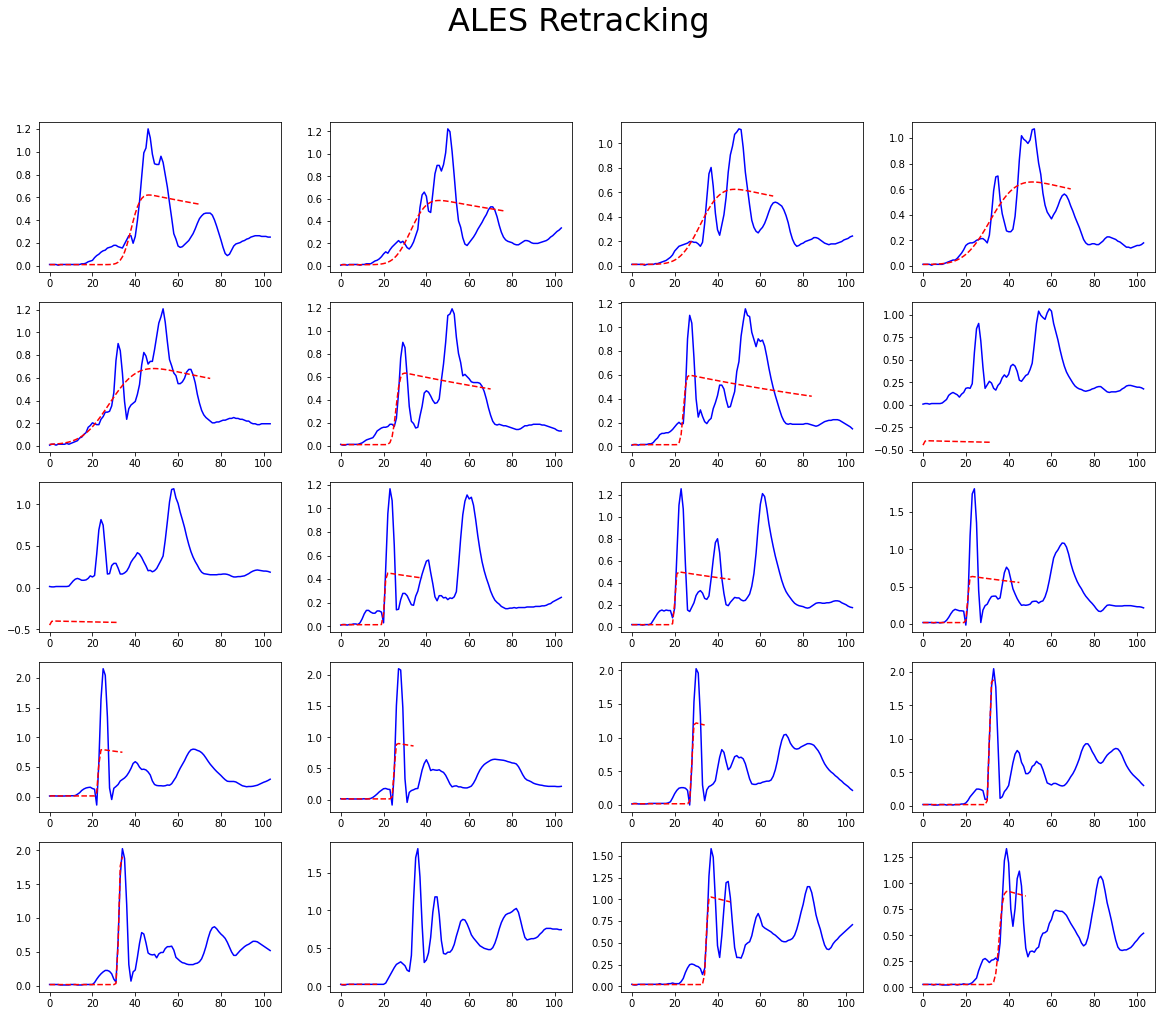

In [25]:
plt.figure(figsize = (20,16))
for i in range(20):
    plt.subplot(5,4,i+1)
    ales,max_gate,T_n = ALES(w[i],0)
    plt.plot(normalize(w[i]),color='blue')
    plt.plot(Brown_Hayne(ales[0], ales[1], ales[2],np.arange(0,max_gate*3.125e-9,3.125e-9),0)+T_n,color='red',linestyle='--')
  #  plt.plot([LEP + W,LEP + W],[0,A],color = 'red', linestyle = 'dashed' )
  #  plt.plot(COG,A/2,color = 'red', marker = 'o')
#plt.supxlabel('Bins')
#plt.supylabel('Return Power')
plt.suptitle('ALES Retracking', fontsize=32)
plt.show()

<h1><center><b>Threshold Retracking</b></center></h1>

In [26]:
def threshold(P,q):
    import numpy as np
    P_4 = np.sum(P**4)
    P_2 = np.sum(P**2)
    A = (P_4/P_2)**(0.5)
    Pn = np.sum(P[0:5])/5
    Th = (A - Pn)*q + Pn
    Gk_1 = 0
    for i in range(len(P)):
        if P[i] > Th:
            Gk_1 = i - 1
            break
    Gr = Gk_1 + (Th - P[Gk_1])/(P[Gk_1 + 1] - P[Gk_1])

<h1><center><b>Stravtzky-Golay</b></center></h1>

In [27]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [28]:
realXIndex = np.where(waveforms.mask)[0]
realXIndex

array([  11,   12,   12, ..., 2546, 2546, 2546], dtype=int64)

In [29]:
waveforms = np.delete(waveforms,np.unique(realXIndex),axis=0)
waveforms.shape

(2433, 20, 104)

In [30]:
savgol = np.zeros((4,24))
for o in range(1,5):
    for w in range(5,52,2):
        R = np.zeros((2433,20))
        for i in range(2433):
            for j in range(20):
                R[i,j] = rmse(savgol_filter(waveforms[i,j],w,o),waveforms[i,j])
        savgol[np.int32(o-1),np.int32((w-5)/2)] = np.median(R)
        

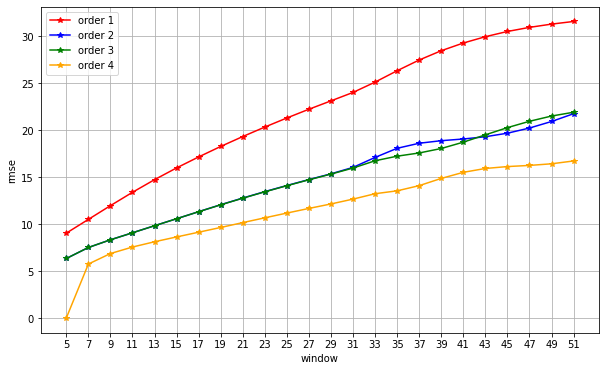

In [31]:
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(range(5,52,2),savgol[0],marker='*',color='red',label='order 1')
plt.plot(range(5,52,2),savgol[1],marker='*',color='blue',label='order 2')
plt.plot(range(5,52,2),savgol[2],marker='*',color='green',label='order 3')
plt.plot(range(5,52,2),savgol[3],marker='*',color='orange',label='order 4')
#plt.plot(range(5,52,2),savgol[4],marker='*',color='yellow',label='order 5')
plt.legend()
plt.xticks(range(5,52,2))
plt.xlabel('window')
plt.ylabel('rmse')
plt.show()